# Pipeline 1: predicting missing values for activity

## Section 1: Loading event log

In [1]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stringdist: filename=StringDist-1.0.9-cp38-cp38-linux_x86_64.whl size=24938 sha256=b4a0a799a61b61628127fcb145542f7c5054a885b129ea42cd9b2f6421ab384a
  Stored in directory: /root/.cache/pip/wheels/7a/64/e2/16f6a25a62a78f951c1715adb24ba2271ae9d7872f42378c3a
Successfully built stringdist


In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
# this assumes that the user has access to the mimic-iii dataset 
# replace project name to the project containing mimic-iii
project_name = "processmining-367815" 
from google.cloud import bigquery
client = bigquery.Client(project=project_name)

In [4]:
import requests

# read a query from the github repository
# change depending on which branch the queries have been pushed to
branch = "sql-queries" 
# change this to change which query is being used
query_name = "event_log_mvp.sql"
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{branch}/sql_queries/{query_name}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

In [5]:
import pandas as pd

# loading event log from bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,109129,Discharged,2188-08-01 12:04:00
1,121510,Discharged,2133-04-23 15:52:00
2,106469,Discharged,2109-02-23 12:01:00
3,133732,Discharged,2167-10-16 13:13:00
4,119601,Discharged,2198-02-20 15:33:00
...,...,...,...
140355,121061,Transfer,2126-07-06 22:00:47
140356,150357,Transfer,2168-09-25 13:23:15
140357,166021,Transfer,2146-09-15 03:16:45
140358,137177,Transfer,2193-01-07 16:03:50


## Section 2: Process Discovery

In [6]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-6-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')


Number of cases: 42652
Number of events: 140360
Start events: {'Admitted': 36881, 'Transfer': 5716, 'Discharged': 55}
End events: {'Discharged': 42563, 'Transfer': 85, 'Admitted': 4}


In [8]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model

event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])

In [9]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

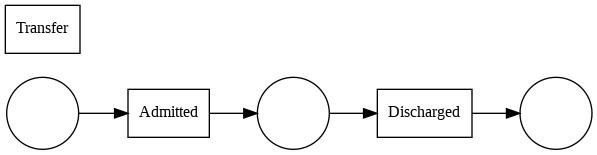

In [10]:
import graphviz
pm.view_petri_net(petri_net=net)

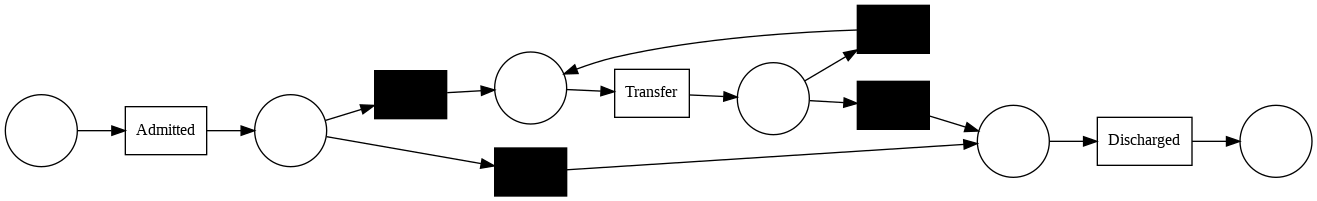

In [11]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

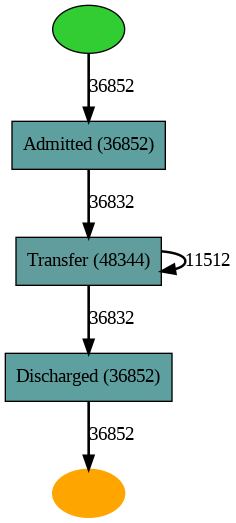

In [12]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

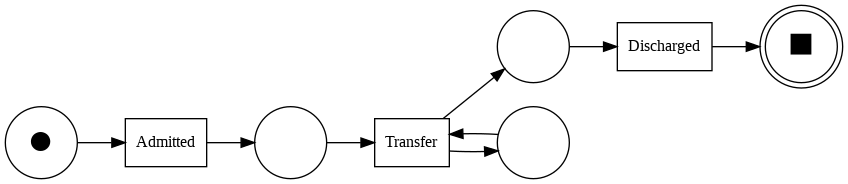

In [13]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

## Section 3: Predicting Missing Activities

In [21]:
from pandas.core.window.ewm import partial
import random
# select the first 100 cases to test the LSTM methodology
# lets first add a trace column to the event_log
event_log['trace'] = event_log.groupby(['patient']).ngroup()

# we can now select 100 random traces,
# this will be repeated with a a larger number of traces
# lets first initialise a random seed
random.seed(9)
num_traces = 100
random_traces = []

for i in range(0,num_traces):
  random_traces.append(random.randrange(0,n_cases))

df = event_log[event_log['trace'].isin(random_traces)]
partial_el = df[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
partial_el

,trace,activity,timestamp
0,253,Admitted,2187-07-25 11:58:00
1,253,Transfer,2187-07-25 11:59:27
2,253,Transfer,2187-07-26 11:56:57
3,253,Discharged,2187-07-30 13:10:00
4,345,Admitted,2108-01-10 22:33:00
...,...,...,...
291,36376,Admitted,2173-05-31 14:23:00
292,36376,Transfer,2173-05-31 14:27:08
293,36376,Transfer,2173-05-31 20:36:45
294,36376,Transfer,2173-06-01 13:11:12


In [63]:
from sklearn.model_selection import train_test_split

# split event log into a train and test set  
pct_train = 0.75

train_traces, test_traces  = train_test_split(random_traces, train_size=pct_train, random_state=9)
train_el = partial_el[partial_el['trace'].isin(train_traces)]
test_el = partial_el[partial_el['trace'].isin(test_traces)]
train_el, test_el

(     trace    activity           timestamp
 0      253    Admitted 2187-07-25 11:58:00
 1      253    Transfer 2187-07-25 11:59:27
 2      253    Transfer 2187-07-26 11:56:57
 3      253  Discharged 2187-07-30 13:10:00
 4      345    Admitted 2108-01-10 22:33:00
 ..     ...         ...                 ...
 291  36376    Admitted 2173-05-31 14:23:00
 292  36376    Transfer 2173-05-31 14:27:08
 293  36376    Transfer 2173-05-31 20:36:45
 294  36376    Transfer 2173-06-01 13:11:12
 295  36376  Discharged 2173-06-09 15:05:00
 
 [217 rows x 3 columns],      trace    activity           timestamp
 7      421    Admitted 2167-11-05 11:09:00
 8      421    Transfer 2167-11-05 11:09:44
 9      421  Discharged 2167-11-11 20:30:00
 36    2830    Admitted 2175-06-19 13:04:00
 37    2830    Transfer 2175-06-19 13:04:48
 ..     ...         ...                 ...
 274  33089    Transfer 2107-02-03 22:25:34
 275  33089  Discharged 2107-02-13 17:18:00
 276  33178    Admitted 2130-05-15 20:04:00
 277  

In [70]:
import numpy as np
# create a new labeled data frame


def label(el):
  # initialise data frame 
  labeled_el = pd.DataFrame(columns=["prefix 1", "prefix 2", "prefix 3",
                                   "suffix 1", "suffix 2", "suffix 3",
                                   "label"])
  index = 0
  unique_traces = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces} 

  for t in unique_traces:
    traces[t] = el[:][el.trace == t]
  
  
  for t in unique_traces:
    df = traces[t].sort_values(by='timestamp')
    activities = []
    for i in df.index:
      activities.append(df['activity'][i])
    
    
    length = len(activities)
    for i in range(length):
      row = []
      prefix = activities[:i]
      label = [activities[i]]
      suffix = []
      if i != length - 1:
        suffix = activities[i+1:]
      
      padding = []
      while len(prefix) + len(padding) < 3:
        padding.append('0')
      
      prefix = padding + prefix
        
      while len(suffix) < 3:
        suffix.append('0')

      row = prefix + suffix + list(label)
      new_row = pd.DataFrame({"prefix 1" : row[0], "prefix 2" : row[1], "prefix 3" : row[2],
                                   "suffix 1" : row[3], "suffix 2" : row[4], "suffix 3" : row[5],
                                   "label" : row[6]}, index=[index])
      index += 1
      labeled_el = labeled_el.append(new_row)

  return labeled_el 

label(train_el)

,prefix 1,prefix 2,prefix 3,suffix 1,suffix 2,suffix 3,label
0,0,0,0,Transfer,Transfer,Discharged,Admitted
1,0,0,Admitted,Transfer,Discharged,0,Transfer
2,0,Admitted,Transfer,Discharged,0,0,Transfer
3,Admitted,Transfer,Transfer,0,0,0,Discharged
4,0,0,0,Transfer,Discharged,0,Admitted
...,...,...,...,...,...,...,...
212,0,0,0,Transfer,Transfer,Transfer,Discharged
213,0,0,Admitted,Transfer,Transfer,Discharged,Transfer
214,0,Admitted,Transfer,Transfer,Discharged,0,Transfer
215,Admitted,Transfer,Transfer,Discharged,0,0,Transfer
